# Tuning the Best FOX Models #

In this notebook, I will select the top three best models and tune their hyperparameters to get the best fit.

| Model | Accuracy |
| ---- | ---- |
| LogisticRegression | 0.867 | 
| KNeighborsClassifier | 0.863 | 
| SVC | 0.844 | 
| LinearSVC | 0.865 | 
| SGDClassifier | 0.842 | 
| DecisionTreeClassifier | 0.874| 
| RandomForestClassifier | 0.891 | 
| BaggingClassifier | 0.899 | 
| GradientBoostingClassifier | 0.880 | 
| AdaBoostClassifier | 0.878 | 

GradientBoosting, RandomForest, and Bagging have the best accuracy so these are the ones I will tune.

In [1]:
import pandas as pd
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize  
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from math import sqrt

In [2]:
fox_df = pd.read_excel('../data/interim/fox_ready_to_code.xlsx').drop(columns=['Unnamed: 0', 'Unnamed: 0.1']).fillna(0)
fox_df.head()

,identifier,start_snip,end_snip,sentence,cluster,ad_cluster,news_cluster,snip_ad,isad,contributor,...,has_next_back,has_prev_ahead,has_next_good evening,has_next_welcome,has_prev_after this,has_next_good morning,has_prev_applause,has_next_applause,has_prev_tuned,has_prev_go away
0,FOXNEWSW_20190528_180000_The_Daily_Briefing_Wi...,0,60,harris: it hasn't been a busy hour.,2,0,0,0,0.0,FOXNEWSW,...,0,0,0,0,0,0,0,0,0,0
1,FOXNEWSW_20190528_180000_The_Daily_Briefing_Wi...,0,60,glad you are long.,2,0,0,0,0.0,FOXNEWSW,...,0,0,0,0,0,0,0,0,0,0
2,FOXNEWSW_20190528_180000_The_Daily_Briefing_Wi...,0,60,got to see air force one with the president co...,2,0,0,0,0.0,FOXNEWSW,...,0,0,0,0,0,0,0,0,0,0
3,FOXNEWSW_20190528_180000_The_Daily_Briefing_Wi...,0,60,keep watching fox news. here is dana.,2,0,0,0,0.0,FOXNEWSW,...,0,0,0,0,0,0,0,0,0,0
4,FOXNEWSW_20190528_180000_The_Daily_Briefing_Wi...,0,60,dana: your daily briefing starts now.,2,0,0,0,0.0,FOXNEWSW,...,0,0,0,0,0,0,0,0,0,0


In [3]:
y = np.array(fox_df['isad'])
X = fox_df.drop(columns=['identifier', 'contributor', 'subjects', 'start_time', 'stop_time', 'runtime',
                        'isad']).dropna()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18)

In [4]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could',
                           '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many',
                           'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily',
                           'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right',
                           'line', 'even', 'also', 'may', 'take', 'come', 'hi', 'ha', 'le', 'u', 'wa', 'thi',
                           'to', 'one'])

In [5]:
def clean_sent(sentences):
    for sent in sentences:
        sent = str(sent)
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = re.sub("([\d,\,\./!#$%&\'\":;>\?@\[\]`)(\+])+", "", sent) # remove digits and remove punctuation
        sent = re.sub("([-])+", " ", sent)
        yield(sent)  

In [6]:
corpus_train = list(clean_sent(X_train.sentence.values.tolist()))
corpus_test = list(clean_sent(X_test.sentence.values.tolist()))
corpus_train[:5]

['they dont want to',
 'and as i said ive put on as a lawyer expert witnesses',
 'bidens website has been updated with citations',
 'all that continues next',
 ' to build on what john said yes pomp circumstance and some politics which donald trump talked about on his trip']

In [7]:
#lemmatize before vectorizing

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

vect = TfidfVectorizer(tokenizer=LemmaTokenizer(), strip_accents='unicode', stop_words='english', 
                       min_df=2, max_df=0.3, ngram_range=(1,2))

In [8]:
X_train_bow = vect.fit_transform(corpus_train)
X_test_bow = vect.transform(corpus_test)
X_train_bow_df = pd.DataFrame(X_train_bow.toarray())
X_train_joined = X_train.reset_index().join(X_train_bow_df).drop(columns=['index'])
X_test_bow_df = pd.DataFrame(X_test_bow.toarray())
X_test_joined = X_test.reset_index().join(X_test_bow_df).drop(columns=['index'])
X_train_joined = X_train_joined.drop(columns=['sentence'])
X_test_joined = X_test_joined.drop(columns=['sentence'])

C:\Users\Administrator\Documents\ad-finder-cc\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [9]:
def plot_confusion_matrix(model, X, y):
    pred = model.predict(X)
    c=confusion_matrix(y, pred)
    sns.heatmap(c,cmap='BrBG',annot=True)
    print(c)
    plt.show()

In [ ]:
params = {'criterion' : ['friedman_mse', 'mse', 'mae'],
         'max_depth' : [10, 50, 75, 100, 200],
         'min_samples_split': [2, 5, 10]}
gbc = ensemble.GradientBoostingClassifier()
cv = RandomizedSearchCV(gbc, params)
cv.fit(X_train_joined, y_train)

# Compute and print metrics
print("Accuracy: {}".format(cv.score(X_test_joined, y_test)))
print("Tuned Model Parameters: {}".format(cv.best_params_))

In [ ]:
plot_confusion_matrix(cv, X_test_joined, y_test)

In [10]:
rfc = ensemble.RandomForestClassifier(criterion='entropy', random_state=18)
params = {'n_estimators': [10, 100, 500, 1000],
         'max_depth' : [10, 50, 100, 200],
         'max_features' : ['sqrt', 'log2', None],
         'min_samples_split': [2, 5, 10]}
cv = RandomizedSearchCV(rfc, params, n_iter=6)
#cv = GridSearchCV(rfc, params)
cv.fit(X_train_joined, y_train)


RandomizedSearchCV(estimator=RandomForestClassifier(criterion='entropy',
                                                    random_state=18),
                   n_iter=6,
                   param_distributions={'max_depth': [10, 50, 100, 200],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 100, 500, 1000]})

In [11]:
# Compute and print metrics
print("Accuracy: {}".format(cv.score(X_test_joined, y_test)))
print("Tuned Model Parameters: {}".format(cv.best_params_))

Accuracy: 0.882
Tuned Model Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 50}


[[2505   28]
 [ 326  141]]


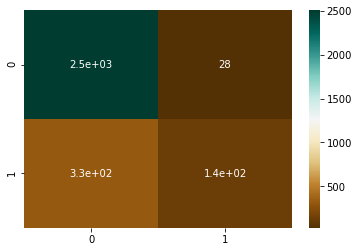

In [12]:
plot_confusion_matrix(cv, X_test_joined, y_test)

In [ ]:
#rfc = ensemble.RandomForestClassifier(criterion='entropy', n_estimators=100, min_samples_split=2,
#                                      max_features='sqrt', random_state=18)
#params = {'max_depth' : [150, 200, 300, 500]}
#cv = RandomizedSearchCV(rfc, params)
#cv = GridSearchCV(rfc, params)
#cv.fit(X_train_joined, y_train)

# Compute and print metrics
#print("Accuracy: {}".format(cv.score(X_test_joined, y_test)))
#print("Tuned Model Parameters: {}".format(cv.best_params_))

That got worse, so let's say these parameters are the best: 

Tuned Model Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 200}

In [13]:
bgc = ensemble.BaggingClassifier(random_state=18)
params = {'n_estimators': [10, 100, 500, 1000],
         'max_features' : [0.25, 0.5, 0.75, 1.0]}
cv = RandomizedSearchCV(bgc, params, n_iter=6)
cv.fit(X_train_joined, y_train)

# Compute and print metrics
print("Accuracy: {}".format(cv.score(X_test_joined, y_test)))
print("Tuned Model Parameters: {}".format(cv.best_params_))

Accuracy: 0.908
Tuned Model Parameters: {'n_estimators': 500, 'max_features': 0.5}
